# Task
Define image transformations, load the image dataset from `/kaggle/input/microsoft-catsvsdogs-dataset` using `torchvision.datasets.ImageFolder`, and create a `DataLoader` for batching, shuffling, and loading the image data.

In [1]:
#import necessary libraries

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import torchvision
from torchvision.transforms import transforms
from torchvision.transforms import ToTensor

import numpy as np

In [9]:
# checking weather its using gpu or cpu

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
#Load the dataset from kaggle

import kagglehub

# Download latest version
path = kagglehub.dataset_download("shaunthesheep/microsoft-catsvsdogs-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'microsoft-catsvsdogs-dataset' dataset.
Path to dataset files: /kaggle/input/microsoft-catsvsdogs-dataset


## Define Image Transformations



In [3]:
#We need to transform because there might be diffferent shape and size in the datasets, so the transforms does the work for us.


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Image transformation pipeline defined.")

Image transformation pipeline defined.


## Load Dataset with ImageFolder



In [4]:
from PIL import Image

def is_valid_file(path):
    try:
        with open(path, 'rb') as f:
            Image.open(f) # Try to open the image
        return True
    except Exception:
        # print(f"Skipping invalid image file: {path}") # Uncomment for debugging
        return False

data_dir = f"{path}/PetImages"
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform, is_valid_file=is_valid_file)

print(f"Total number of images loaded: {len(dataset)}")
print(f"Class names: {dataset.classes}")

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Total number of images loaded: 24998
Class names: ['Cat', 'Dog']


## Create DataLoader




In [5]:
batch_size = 32
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f"DataLoader created with batch size: {batch_size}, shuffle: True, num_workers: 2")
print(f"Number of batches in DataLoader: {len(dataloader)}")

DataLoader created with batch size: 32, shuffle: True, num_workers: 2
Number of batches in DataLoader: 782


# Task
Define a convolutional neural network (CNN) architecture for image classification, including convolutional, pooling, and fully connected layers.

In [6]:
class ImageClassifier(nn.Module):
  def __init__(self, input_shape: int, hidden_units:int, output_shape: int):
      super().__init__()
      self.conv1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2)
        )

      self.conv2 = nn.Sequential(
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2)
        )

      self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=hidden_units*56*56,
                    out_features=output_shape)
      )

  def forward(self, x:torch.Tensor):
    x = self.conv1(x)
    # print(x.shape) # Commented out print statements
    x = self.conv2(x)
    # print(x.shape) # Commented out print statements
    x = self.classifier(x) # Apply the classifier to x
    return x

## Define Loss Function and Optimizer




In [7]:
model = ImageClassifier(input_shape=3, hidden_units=10, output_shape=len(dataset.classes))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"ImageClassifier model initialized: {model}")
print(f"Loss function defined: {loss_fn}")
print(f"Optimizer defined: {optimizer}")

ImageClassifier model initialized: ImageClassifier(
  (conv1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=2, bias=True)
  )
)
Loss function defined: CrossEntropyLoss()
Optimizer defined: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08

## Define Training Function


In [8]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):

    # Set model to train mode
    model.train()

    # Initialize train loss and accuracy
    train_loss, train_acc = 0, 0

    # Loop through batches
    for batch, (X, y) in enumerate(dataloader):
        # Move data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

print("Training step function 'train_step' defined.")

Training step function 'train_step' defined.


## Define Evaluation Function




In [10]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):

    # Set model to eval mode
    model.eval()

    # Initialize test loss and accuracy
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.no_grad():
        # Loop through batches
        for batch, (X, y) in enumerate(dataloader):
            # Move data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

print("Evaluation step function 'test_step' defined.")

Evaluation step function 'test_step' defined.


## Implement Training Loop




In [11]:
train_size = int(0.8 * len(dataset))   # 80% train_size
test_size = len(dataset) - train_size  # 20% test_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Dataset split into {len(train_dataset)} training images and {len(test_dataset)} testing images.")
print(f"Training DataLoader created with {len(train_dataloader)} batches.")
print(f"Testing DataLoader created with {len(test_dataloader)} batches.")

Dataset split into 19998 training images and 5000 testing images.
Training DataLoader created with 625 batches.
Testing DataLoader created with 157 batches.


In [12]:
epochs = 5   #You can use more epochs for better results for now i have used only 5 epochs
results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

# Move model to device
model.to(device)

for epoch in range(epochs):
    train_loss, train_acc = train_step(model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device)

    test_loss, test_acc = test_step(model=model,
                                      dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}")

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

print("\nTraining loop finished.")

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 1 | train_loss: 0.6212 | train_acc: 0.6316 | test_loss: 0.5547 | test_acc: 0.7102
Epoch: 2 | train_loss: 0.5335 | train_acc: 0.7318 | test_loss: 0.5228 | test_acc: 0.7273
Epoch: 3 | train_loss: 0.4737 | train_acc: 0.7734 | test_loss: 0.5132 | test_acc: 0.7466
Epoch: 4 | train_loss: 0.4215 | train_acc: 0.8061 | test_loss: 0.4890 | test_acc: 0.7633
Epoch: 5 | train_loss: 0.3626 | train_acc: 0.8405 | test_loss: 0.5178 | test_acc: 0.7604

Training loop finished.


## Visualize Training Results



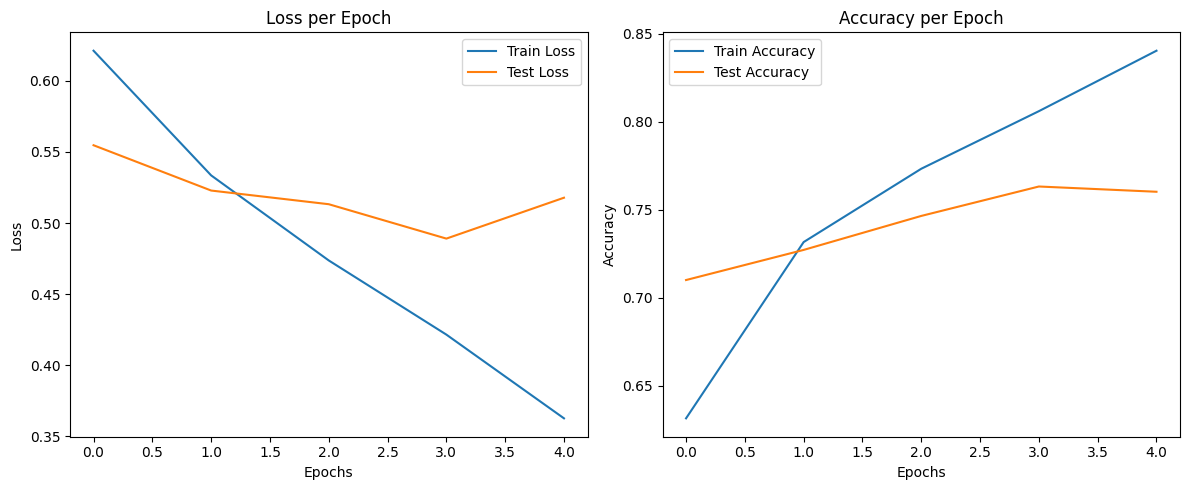

In [13]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(results['train_loss'], label='Train Loss')
plt.plot(results['test_loss'], label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(results['train_acc'], label='Train Accuracy')
plt.plot(results['test_acc'], label='Test Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Make Predictions



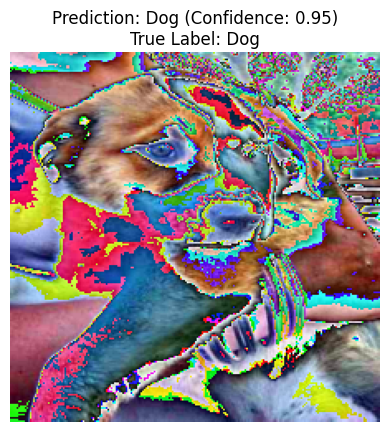

Predicted class: Dog with confidence 0.95
True label: Dog


In [23]:
def predict_image(model: torch.nn.Module, image_path: str, transform, class_names: list, device: torch.device):
    model.eval()
    with torch.no_grad():
        image = Image.open(image_path).convert('RGB')
        transformed_image = transform(image).unsqueeze(0) # Add batch dimension
        transformed_image = transformed_image.to(device)

        # Make prediction
        output = model(transformed_image)
        probabilities = torch.softmax(output, dim=1)
        predicted_class_idx = torch.argmax(probabilities, dim=1).item()

    return class_names[predicted_class_idx], probabilities[0][predicted_class_idx].item()


# Get an example image from the test dataset
import random

# Select a random index from the test dataset
random_idx = random.randint(0, len(test_dataset) - 1)

# Get the image and label at the random index
example_image_tensor, example_true_label = test_dataset[random_idx]

# Convert tensor to PIL Image to save for prediction
example_image_pil = transforms.ToPILImage()(example_image_tensor)
example_image_pil.save('temp_example_image.jpg') # Save to a temporary file

# Make prediction using the predict_image function
predicted_class, confidence = predict_image(model=model,
                                            image_path='temp_example_image.jpg',
                                            transform=transform,
                                            class_names=dataset.classes,
                                            device=device)

# Get the  class name
true_class = dataset.classes[example_true_label]

# Display the image and results
plt.imshow(example_image_pil)
plt.title(f"Prediction: {predicted_class} (Confidence: {confidence:.2f})\nTrue Label: {true_class}")
plt.axis('off')
plt.show()

print(f"Predicted class: {predicted_class} with confidence {confidence:.2f}")
print(f"True label: {true_class}")

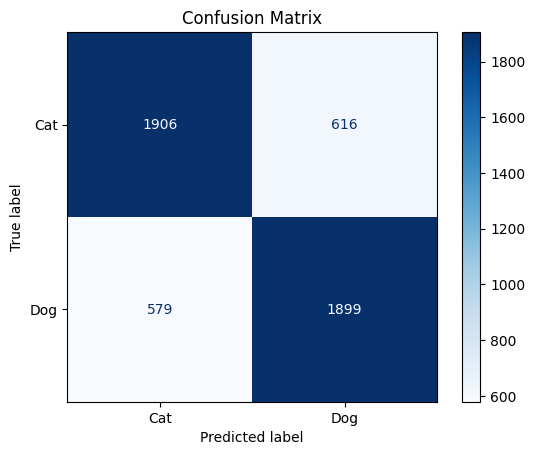

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the test dataset
model.eval()
y_preds = []
y_true = []
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_logits = model(X)
        y_pred_labels = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
        y_preds.append(y_pred_labels.cpu())
        y_true.append(y.cpu())

y_pred_tensor = torch.cat(y_preds)
y_true_tensor = torch.cat(y_true)

# Calculate confusion matrix using sklearn
cm = confusion_matrix(y_true_tensor.numpy(), y_pred_tensor.numpy())

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()